<a href="https://colab.research.google.com/github/EnmaAii/Ex.2_Digital_Culture/blob/main/_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 2

Задание - создать нейросеть, умеющую различать рукописные цифры. Можно использовать встроенные нейросети, например, ResNet50 или ResNet18. По аналогии с прошлой работой можно менять количество весов и любые другие параметры модели. В случае, если вы берёте ResNet из примера, замораживание весов может быть не обязательным (проверить!). Минимальная точность на тестовых данных для получения зачета 96%.
Датасет загрузить с kaggle.com по ссылке ниже. Выполнить все указания ниже.

Контрольные вопросы - см. вопросы из ЛР1 и вопросы ниже:
1. В чем особенность архитектуры ResNet?
2. Какие стандарты цветовых моделей, помимо RGB, вы знаете?
3. Зачем мы используем функцию transform?
4. Какая библиотека в Python считывает изображения и в виде какого типа данных хранит их?
5. Требуется ли в этой работе разделять данные на тренировочные и тестовые?
6. Перемешивает ли даннные загрузчик (Dataloader)?


https://www.kaggle.com/datasets/jidhumohan/mnist-png

In [ ]:
!echo '{"username":"galya","key":"9aec456145fa8494b7c42a79d2fc5b6e"}' > kaggle.json

In [ ]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls /root/.kaggle/

kaggle.json


In [ ]:
!kaggle datasets download -d jidhumohan/mnist-png

Dataset URL: https://www.kaggle.com/datasets/jidhumohan/mnist-png
License(s): DbCL-1.0
 72% 42.0M/58.6M [00:00<00:00, 94.1MB/s]
100% 58.6M/58.6M [00:00<00:00, 105MB/s] 


In [ ]:
%ls


kaggle.json  mnist-png.zip  sample_data/


In [ ]:
!unzip mnist-png

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: mnist_png/training/9/1820.png  
  inflating: mnist_png/training/9/18211.png  
  inflating: mnist_png/training/9/18228.png  
  inflating: mnist_png/training/9/18241.png  
  inflating: mnist_png/training/9/18251.png  
  inflating: mnist_png/training/9/1826.png  
  inflating: mnist_png/training/9/18277.png  
  inflating: mnist_png/training/9/18296.png  
  inflating: mnist_png/training/9/183.png  
  inflating: mnist_png/training/9/18350.png  
  inflating: mnist_png/training/9/18355.png  
  inflating: mnist_png/training/9/18374.png  
  inflating: mnist_png/training/9/18377.png  
  inflating: mnist_png/training/9/18382.png  
  inflating: mnist_png/training/9/18387.png  
  inflating: mnist_png/training/9/18401.png  
  inflating: mnist_png/training/9/18405.png  
  inflating: mnist_png/training/9/18415.png  
  inflating: mnist_png/training/9/18437.png  
  inflating: mnist_png/training/9/18441.png  
  inflating: mni

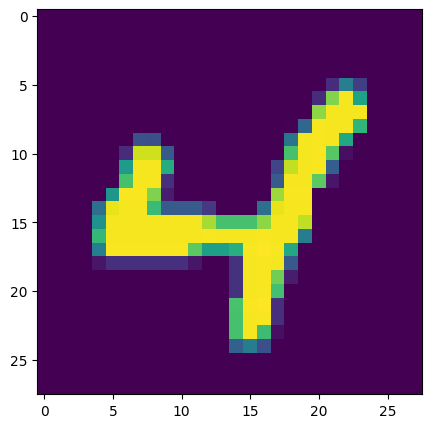

In [ ]:
import matplotlib.pyplot as plt

path_to_img = '/content/mnist_png/training/4/10013.png'
image = plt.imread(path_to_img)
plt.figure(figsize=(12,5))
plt.imshow(image);

In [ ]:
classes = [i for i in range(0, 10)]

In [ ]:
import os
file_list_train = []
answer_train = []
for folder in classes: #listdir - список папок в аргументе()
  for file_name in os.listdir('./mnist_png/training/' + str(folder)):
    file_list_train.append('./mnist_png/training/' + str(folder) + "/" + file_name)
    answer_train.append(folder)

In [ ]:
file_list_test = []
answer_test = []
for folder in os.listdir('./mnist_png/testing'):
  for file_name in os.listdir('./mnist_png/testing/' + folder):
    file_list_test.append('./mnist_png/testing/' + folder + "/" + file_name)
    answer_test.append(int(folder))

Создадим функцию для обработки изображений перед их передачей в датасет (transform из условия задания и шпаргалки):

Зачем нужен transform? Затем, что изображения должны быть в одинаковом формате.

In [ ]:
from torchvision import transforms
# transform из условия задания и шпаргалки
transform = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Делаем основу для датасета

In [ ]:
from torch.utils.data import Dataset
from skimage import io

class MNISTDataset(Dataset):
    def __init__(self, file_list, answer_list, transform):
        self.file_list = file_list
        self.answer_list = answer_list
        self.transform = transform
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image = io.imread(self.file_list[idx])
        image = self.transform(image)
        label = self.answer_list[idx]
        return image, label

Создаём тренировочный и тестовый датасет

In [ ]:
trainset = MNISTDataset(file_list_train, answer_train, transform)
testset = MNISTDataset(file_list_test, answer_test, transform)

Загружать наши датасеты в нейронную сеть будут специально обученные механизмы - DataLoader'ы

In [ ]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=4, shuffle=True, num_workers=0)


In [ ]:
from matplotlib import pyplot as plt
import torchvision
import numpy as np
dataiter = iter(testloader) #итератор - ссылка на датасет
input, labels = next(dataiter) #next при каждом вызове возвращает 1, 2, 3 элемент... пока не кончатся.
#когда next дойдет до конца - следующий next вернет исключение.

Cоздаём нейронную сеть

In [ ]:
import torch
cuda0 = torch.device('cuda:0')


Загружаем предварительно натренированную сеть:

In [ ]:
from torchvision import models
import torch.optim as optim
import torch.nn as nn

net = models.resnet18(pretrained=True) # resnet18 - 18 слоёв
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
net.fc = nn.Linear(num_features, 10)
# В качестве cost function используем кросс-энтропию
criterion = nn.CrossEntropyLoss() #log loss
# В качестве оптимизатора - стохастический градиентный спуск
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



net = net.to(cuda0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


Тренируем нашу сеть (у нас огромный датасет, поэтому тренироваться она будет долго, про оптимизацию вычислений поговорим в следующий раз):

In [ ]:
losses = []
running_corrects = 0
running_loss = 0.0

net.train(True)
for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)

        optimizer.zero_grad()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_corrects += int(torch.sum(preds == labels.data)) / len(labels)
        if i % 100 == 99:
          print('[%d, %5d] loss: %.3f accuracy: %.3f' % (epoch + 1, i + 1, running_loss/100, running_corrects/100 ))
          losses += [running_loss/100]
          running_loss = 0.0
          running_corrects = 0.0

print('Finished Training')

[1,   100] loss: 1.502 accuracy: 0.522
[1,   200] loss: 0.490 accuracy: 0.875
[1,   300] loss: 0.404 accuracy: 0.887
[1,   400] loss: 0.284 accuracy: 0.930
[1,   500] loss: 0.303 accuracy: 0.907
[1,   600] loss: 0.217 accuracy: 0.927
[1,   700] loss: 0.210 accuracy: 0.940
[1,   800] loss: 0.172 accuracy: 0.940
[1,   900] loss: 0.200 accuracy: 0.935
[1,  1000] loss: 0.160 accuracy: 0.955
[1,  1100] loss: 0.183 accuracy: 0.935
[1,  1200] loss: 0.189 accuracy: 0.953
[1,  1300] loss: 0.204 accuracy: 0.945
[1,  1400] loss: 0.131 accuracy: 0.960
[1,  1500] loss: 0.108 accuracy: 0.965
[1,  1600] loss: 0.123 accuracy: 0.968
[1,  1700] loss: 0.144 accuracy: 0.960
[1,  1800] loss: 0.134 accuracy: 0.963
[1,  1900] loss: 0.120 accuracy: 0.970
[1,  2000] loss: 0.149 accuracy: 0.958
[1,  2100] loss: 0.185 accuracy: 0.943
[1,  2200] loss: 0.130 accuracy: 0.970
[1,  2300] loss: 0.124 accuracy: 0.975
[1,  2400] loss: 0.097 accuracy: 0.975
[1,  2500] loss: 0.172 accuracy: 0.955
[1,  2600] loss: 0.165 ac

Дополнительная иллюстрация на одном батче (здесь делать ничего не нужно, можно использовать для проверки своей НС):

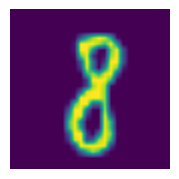

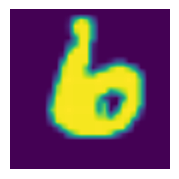

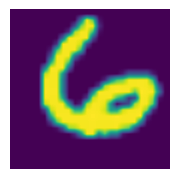

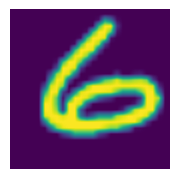

In [ ]:
for img in data[0]:
  plt.figure(figsize=(7,3))
  plt.subplot(131)
  plt.axis('off')
  plt.imshow(img[0])

В data[1] содержится информация о классах:

график loss

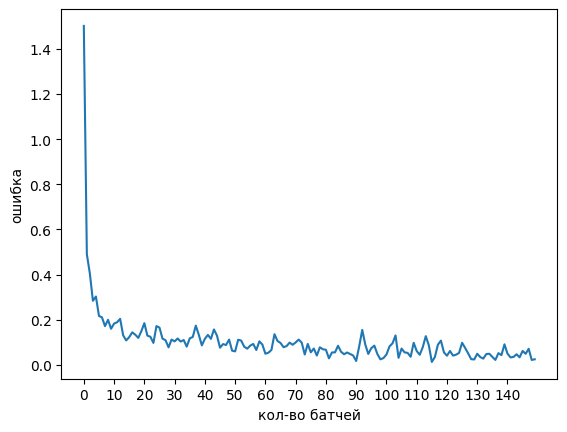

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('кол-во батчей')
plt.ylabel('ошибка')
plt.xticks(list(range(0, len(losses), 10)))
plt.show()

In [ ]:
running_corrects = 0
num_of_tests = 0
net.train(False)
for epoch in range(1):
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)

        output = net(inputs)

        _, preds = torch.max(output, 1)

        running_corrects += int(torch.sum(preds == labels.data)) / len(labels)
        num_of_tests +=1

print(running_corrects / num_of_tests)

0.9937


In [ ]:
data[1]

tensor([8, 6, 9, 7])

Обратим внимание на размерность данных из батча - пригодится позже:

In [ ]:
data[0].size()

torch.Size([4, 3, 244, 244])

4 картинки, каждая представляет из себя 3 слоя 244 на 244.

Нейросеть возвращает 4 строчки по 10 чисел - вероятности принадлежности к каждой цифре:

In [ ]:
net(data[0].to(cuda0))

tensor([[-5.4730, -2.1924, -2.8110, -0.1319, -1.0355,  2.8591,  1.0296, -3.1970,
         11.2409, -1.6609],
        [-1.8467,  0.4748, -1.4435, -6.4340, -5.7646,  2.5901, 12.4319, -4.2344,
         -0.4409,  1.0058],
        [-1.2480, -1.4495, -0.0842, -3.4863,  0.7326, -1.2138, -2.7168, -0.8545,
          0.1789,  9.9888],
        [ 0.2804, -0.2284, -2.7290, -0.7681, -0.7235, -2.8654, -5.9907, 12.5487,
          2.0333, -0.7068]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
preds = torch.max(net(data[0].to(cuda0)), 1)[1]
preds = preds.cpu().detach().numpy() #в numpy для красивого вывода
preds

array([8, 6, 9, 7])

In [ ]:
print("Digits: ", *preds)

Digits:  8 6 9 7


In [ ]:
print("Digits: ", *[np.argmax(res.cpu().detach().numpy()) for res in net(data[0].to(cuda0))])

Digits:  8 6 9 7


здесь .cpu() - метод для обратного переноса тензора из CUDA, чтобы его можно было конвертировать в numpy-массив и найти с помощью np.argmax максимальный элемент.

А теперь проверим какую-то конкретную фотографию:

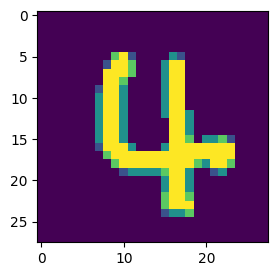

In [ ]:
path = '/content/mnist_png/testing/4/1023.png'
test_img = plt.imread(path)
plt.figure(figsize=(7,3))
plt.imshow(test_img);

Трансформируем в удобный для нейросети вид:

In [ ]:
test_img = transform(test_img)
test_img = test_img.reshape(1, 3, 244, 244)
test_img = test_img.to(cuda0)
test_img.size()

torch.Size([1, 3, 244, 244])

Ответ:

In [ ]:
ans = net(test_img)
print('Digit:', np.argmax(ans.cpu().detach().numpy()))

Digit: 4
